In [ ]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

# 폰트 설정
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire


MLP (Best threshold: 0.52)
              precision    recall  f1-score   support

      재직자(0)       0.61      0.71      0.66      2000
      퇴사자(1)       0.65      0.55      0.60      2000

    accuracy                           0.63      4000
   macro avg       0.63      0.63      0.63      4000
weighted avg       0.63      0.63      0.63      4000


DeepMLP (Best threshold: 0.50)
              precision    recall  f1-score   support

      재직자(0)       0.63      0.59      0.61      2000
      퇴사자(1)       0.61      0.66      0.63      2000

    accuracy                           0.62      4000
   macro avg       0.62      0.62      0.62      4000
weighted avg       0.62      0.62      0.62      4000


CNN1D (Best threshold: 0.51)
              precision    recall  f1-score   support

      재직자(0)       0.51      0.51      0.51      2000
      퇴사자(1)       0.51      0.51      0.51      2000

    accuracy                           0.51      4000
   macro avg       0.51      0.51     

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46373 (\N{HANGUL SYLLABLE DIB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45789 (\N{HANGUL SYLLABLE NING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

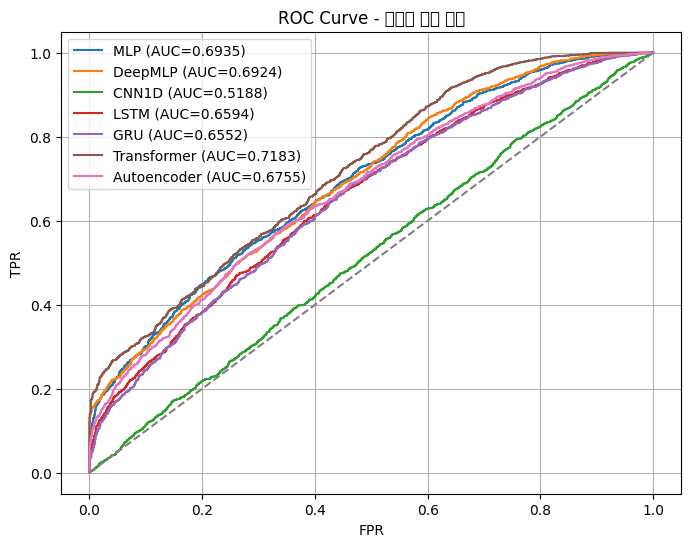

In [1]:
###딥러닝만, HYPERPARAMETER 설정을 하지 않고.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, roc_curve, auc
)

# 📌 데이터 로드 및 전처리
df = pd.read_csv('/content/employee_new3.csv')
df = df[df['Gender'] != 'Other']  # 이상치 제거
df['Resigned'] = df['Resigned'].astype(int)
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=['Resigned', 'Employee_ID', 'Hire_Date'], errors='ignore')
y = df['Resigned']

# 클래스 균형 맞춤
X_0 = X[y == 0].sample(n=10000, random_state=42)
y_0 = y[y == 0].sample(n=10000, random_state=42)
X_1 = X[y == 1]
y_1 = y[y == 1]
repeat_count = 10000 // len(X_1) + 1
X_1_sampled = pd.concat([X_1] * repeat_count)[:10000].reset_index(drop=True)
y_1_sampled = pd.concat([y_1] * repeat_count)[:10000].reset_index(drop=True)
X_balanced = pd.concat([X_0, X_1_sampled]).reset_index(drop=True)
y_balanced = pd.concat([y_0, y_1_sampled]).reset_index(drop=True)

# 스케일링 및 분할
X_balanced = X_balanced.fillna(X_balanced.mean(numeric_only=True))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=512, shuffle=True)

# 🧠 다양한 딥러닝 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.model(x)

class DeepMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.model(x)

class CNN1D(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

# LSTM 모델
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, F]
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# GRU 모델
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

# Transformer 모델
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.linear_in = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, F]
        x = self.linear_in(x)
        out = self.transformer(x)
        return self.fc(out[:, -1, :])

# Autoencoder 기반 이진 분류기
class AutoencoderClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
        )
        self.classifier = nn.Linear(32, 1)

    def forward(self, x):
        encoded = self.encoder(x)
        return self.classifier(encoded)

# ⚙️ 학습 함수
def train_model(model, name):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()
    model.train()
    for epoch in range(10):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(X_test_tensor)).numpy().flatten()
    return probs

# 📊 평가 함수
def evaluate(name, y_true, probs):
    best_f1, best_th = 0, 0.5
    for th in np.arange(0.1, 0.9, 0.01):
        pred = (probs >= th).astype(int)
        f1_0 = f1_score(y_true, pred, pos_label=0)
        f1_1 = f1_score(y_true, pred, pos_label=1)
        avg = (f1_0 + f1_1) / 2
        if avg > best_f1:
            best_f1 = avg
            best_th = th
    final_pred = (probs >= best_th).astype(int)
    print(f"\n{name} (Best threshold: {best_th:.2f})")
    print(classification_report(y_true, final_pred, target_names=["재직자(0)", "퇴사자(1)"]))
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.4f})")
    return roc_auc

# ✅ 모델 실행 및 비교
models = {
    "MLP": MLP(X_train.shape[1]),
    "DeepMLP": DeepMLP(X_train.shape[1]),
    "CNN1D": CNN1D(X_train.shape[1]),
    "LSTM": LSTMModel(X_train.shape[1]),
    "GRU": GRUModel(X_train.shape[1]),
    "Transformer": TransformerModel(X_train.shape[1]),
    "Autoencoder": AutoencoderClassifier(X_train.shape[1])
}

plt.figure(figsize=(8,6))
for name, model in models.items():
    probs = train_model(model, name)
    evaluate(name, y_test, probs)
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve - 딥러닝 모델 비교")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()